In [73]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras import backend as K
from keras.layers import Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization,LeakyReLU
from keras.layers import concatenate
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.random import set_seed
import tensorflow as tf

set_seed(123)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
set_seed(2)
np.random.seed(1)

print(os.listdir("dataset_updated/"))

['.ipynb_checkpoints', 'training_set', 'validation_set']


In [74]:
ImagePath="dataset_updated/training_set/painting/"

(224, 224, 3)

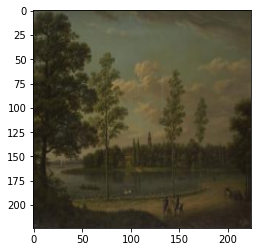

In [75]:
img = cv2.imread(ImagePath+"1179.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)
img.shape

In [76]:
HEIGHT=224
WIDTH=224
ImagePath="dataset_updated/training_set/painting/"

def ExtractInput(path):
    X_img=[]
    y_img=[]
    for imageDir in os.listdir(ImagePath):
        try:
            img = cv2.imread(ImagePath + imageDir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
            img = img.astype(np.float32)
            img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
            #Convert the rgb values of the input image to the range of 0 to 1
            #1.0/255 indicates that we are using a 24-bit RGB color space.
            #It means that we are using numbers between 0–255 for each color channel
            #img_lab = 1.0/225*img_lab
            # resize the lightness channel to network input size 
            img_lab_rs = cv2.resize(img_lab, (WIDTH, HEIGHT)) # resize image to network input size
            img_l = img_lab_rs[:,:,0] # pull out L channel
            #img_l -= 50 # subtract 50 for mean-centering
            img_ab = img_lab_rs[:,:,1:]#Extracting the ab channel
            img_ab = img_ab/128
            #The true color values range between -128 and 128. This is the default interval 
            #in the Lab color space. By dividing them by 128, they too fall within the -1 to 1 interval.
            X_img.append(img_l)
            y_img.append(img_ab)
        except:
            pass
    X_img = np.array(X_img)
    y_img = np.array(y_img)
    
    return X_img,y_img

In [77]:
X_,y_ = ExtractInput(ImagePath) # Data-preprocessing

In [78]:
# X_train,X_val,y_train,y_val = train_test_split(X_,y_, random_state=42)

In [79]:
K.clear_session()
def InstantiateModel(in_):
    model_ = Conv2D(16,(3,3),padding='same',strides=1)(in_)
    model_ = LeakyReLU()(model_)
    #model_ = Conv2D(64,(3,3), activation='relu',strides=1)(model_)
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(64,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(256,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    #model_ = BatchNormalization()(model_)
    
    concat_ = concatenate([model_, in_]) 
    
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(concat_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    #model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(model_)

    return model_

In [80]:
Input_Sample = Input(shape=(HEIGHT, WIDTH,1))
Output_ = InstantiateModel(Input_Sample)
Model_Colourization = Model(inputs=Input_Sample, outputs=Output_)

In [81]:
LEARNING_RATE = 0.001
Model_Colourization.compile(optimizer=Adam(lr=LEARNING_RATE),
                            loss='mean_squared_error')
Model_Colourization.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 224, 224, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [82]:
def GenerateInputs(X_,y_):
    for i in range(len(X_)):
        X_input = X_[i].reshape(1,224,224,1)
        y_input = y_[i].reshape(1,224,224,2)
        yield (X_input,y_input)
Model_Colourization.fit(GenerateInputs(X_,y_),epochs=53,verbose=1,steps_per_epoch=38,shuffle=True)

Epoch 1/53
38/38 [==============================] - 72s 2s/step - loss: 0.0774
Epoch 2/53
38/38 [==============================] - 65s 2s/step - loss: 0.0094
Epoch 3/53
38/38 [==============================] - 68s 2s/step - loss: 0.0022
Epoch 4/53
38/38 [==============================] - 66s 2s/step - loss: 0.0014
Epoch 5/53
38/38 [==============================] - 66s 2s/step - loss: 0.0010
Epoch 6/53
38/38 [==============================] - 73s 2s/step - loss: 0.0010
Epoch 7/53
38/38 [==============================] - 67s 2s/step - loss: 7.9012e-04
Epoch 8/53
38/38 [==============================] - 67s 2s/step - loss: 9.0723e-04
Epoch 9/53
38/38 [==============================] - 64s 2s/step - loss: 0.0190
Epoch 10/53
38/38 [==============================] - 61s 2s/step - loss: 0.0011
Epoch 11/53
38/38 [==============================] - 65s 2s/step - loss: 3.1881e-04
Epoch 12/53
38/38 [==============================] - 63s 2s/step - loss: 2.9096e-04
Epoch 13/53
38/38 [==============

In [83]:
TestImagePath="dataset_updated/training_set/iconography/"

In [84]:
def ExtractTestInput(ImagePath):
    img = cv2.imread(ImagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_ = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2Lab)
    img_=img_.astype(np.float32)
    img_lab_rs = cv2.resize(img_, (WIDTH, HEIGHT)) # resize image to network input size
    img_l = img_lab_rs[:,:,0] # pull out L channel
    #img_l -= 50
    img_l_reshaped = img_l.reshape(1,224,224,1)
    
    return img_l_reshaped

In [85]:
ImagePath=TestImagePath+"15.jpg"
image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Colourization.predict(image_for_test)
Prediction = Prediction*128
Prediction=Prediction.reshape(224,224,2)

1/1 [==============================] - 1s 1s/step


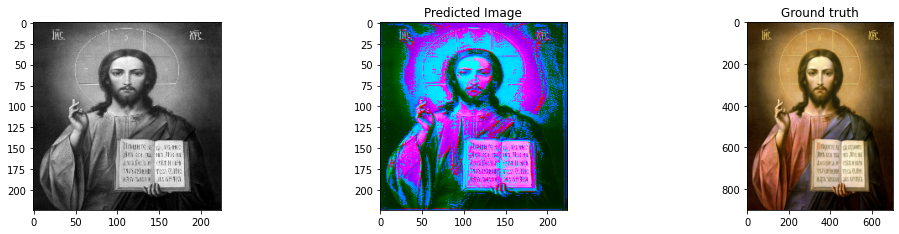

In [86]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath+"15.jpg")
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)